In [3]:
%load_ext autoreload
%autoreload 2
from IPython.display import SVG, display
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from m3util.viz.style import set_style
from m3util.viz.layout import layout_fig, layout_subfigures_inches
from m3util.viz.text import labelfigs
from m3util.viz.printing import printer
printing = printer(basepath = '../../figures/4.AttentionMap/', fileformats=['png', 'svg', 'tif'], dpi=600)


from dl_utils.utils.utils import list_to_dict, sort_tasks_by_size, viz_h5_structure, find_symm_index_in_hdf5, fetch_img_metadata
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, fpn_resnet50_classification, densenet161_, xcit_small
from dl_utils.analysis.case_analysis import prediction_vs_actual, most_confused_pairs, find_confused_sample, show_prediction_example
from dl_utils.analysis.attention_map import AttentionMapVisualizer
from dl_utils.analysis.attention_map import generate_attention_maps
set_style("printing")


symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)
bs = 64
num_workers = 1
device = torch.device('cpu')

# imagenet
imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10m_fix_vector.h5', folder='imagenet', transform=transforms.ToTensor(), classes=symmetry_classes)
train_ds, valid_ds = split_train_valid(imagenet_ds, 0.8)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=num_workers)

# atom
atom_ds = hdf5_dataset('../../datasets/atom_v5_rot_1m_fix_vector.h5', folder='atom', transform=transforms.ToTensor(), classes=symmetry_classes)
atom_dl = DataLoader(atom_ds, batch_size=bs, shuffle=True, num_workers=num_workers)

# noise
noise_ds = hdf5_dataset('../../datasets/noise_v5_rot_1m_fix_vector.h5', folder='noise', transform=transforms.ToTensor(), classes=symmetry_classes)
noise_dl = DataLoader(noise_ds, batch_size=bs, shuffle=True, num_workers=num_workers)

resnet50_10k = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
resnet50_10k.load_state_dict(torch.load('../../models/ResNet50/03132025-ResNet50-benchmark-10k/epoch_14900-valid:loss=2.35,acc=0.63.pth', weights_only=True, map_location=device))

resnet50_100k = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
resnet50_100k.load_state_dict(torch.load('../../models/ResNet50/03132025-ResNet50-benchmark-100k/epoch_1210.pth', weights_only=True, map_location=device))

resnet50_10m = resnet50_(in_channels=3, n_classes=len(symmetry_classes))
resnet50_10m.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/epoch_23.pth', weights_only=True, map_location=device))

xcit_10k = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
xcit_10k.load_state_dict(torch.load('../../models/XCiT/03132025-XCiT-benchmark-10k/epoch_6600.pth', weights_only=True, map_location=device))

xcit_100k = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
xcit_100k.load_state_dict(torch.load('../../models/XCiT/09302024-XCiT-dataset_v5_size-100k/model_epoch_300.pth', weights_only=True, map_location=device))

xcit_10m = xcit_small(in_channels=3, n_classes=len(symmetry_classes))
xcit_10m.load_state_dict(torch.load('../../models/XCiT/03132025-XCiT-benchmark-10m/epoch_24.pth', weights_only=True, map_location=device))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn


<All keys matched successfully>

### p4->p4 examples

In [ ]:
overlay_imgs = {}

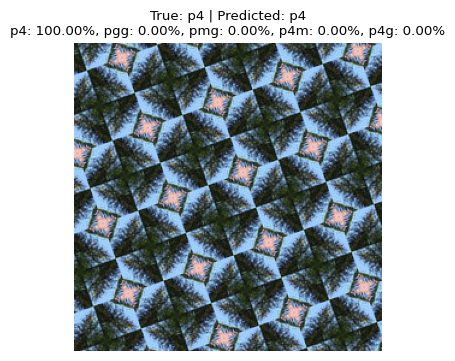

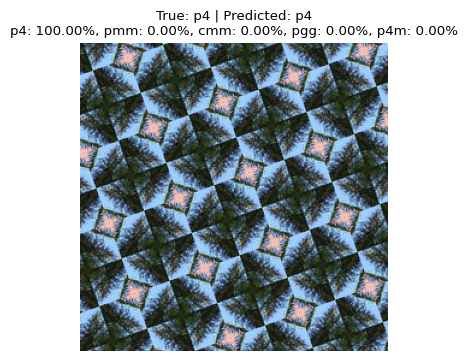

In [10]:
confusion_pair = ('p4', 'p4')
image, label_str, metadata = find_confused_sample(resnet50_100k, valid_dl, confusion_pair, symmetry_classes, device, batch_limit=100, group=None)
# info = show_prediction_example(image, resnet50, confusion_pair, symmetry_classes, device, k=5, metadata=None)
info = show_prediction_example(image, xcit_10k, confusion_pair, symmetry_classes, device, k=5, metadata=None)

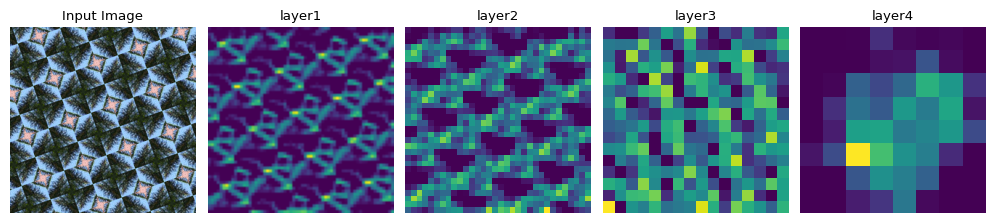

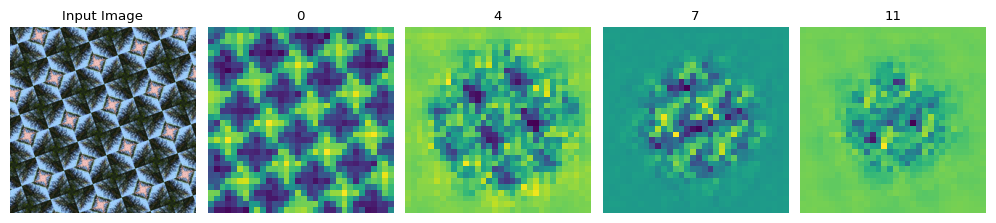

In [11]:
overlay_imgs['p4_p4'] = image

model_type = 'ResNet50'
layers = ['layer1', 'layer2', 'layer3', 'layer4']

task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, resnet50_100k, model_type, device, filename=None, viz=True)
overlay_imgs['ResNet50_layer1_p4_p4'] = overlay_attention_map_list[0]
overlay_imgs['ResNet50_layer2_p4_p4'] = overlay_attention_map_list[1]
overlay_imgs['ResNet50_layer3_p4_p4'] = overlay_attention_map_list[2]
overlay_imgs['ResNet50_layer4_p4_p4'] = overlay_attention_map_list[3]

model_type = 'XCiT'
layers = [0, 4, 7, 11]
task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, xcit_100k, model_type, device, filename=None, viz=True)
overlay_imgs['XCiT_layer0_p4_p4'] = overlay_attention_map_list[0]
overlay_imgs['XCiT_layer4_p4_p4'] = overlay_attention_map_list[1]
overlay_imgs['XCiT_layer7_p4_p4'] = overlay_attention_map_list[2]
overlay_imgs['XCiT_layer11_p4_p4'] = overlay_attention_map_list[3]


### p4 -> pgg example

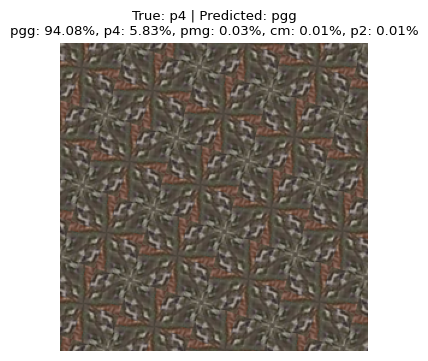

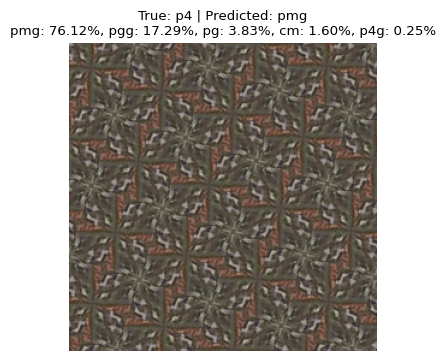

In [12]:
confusion_pair = ('p4', 'pgg')
image, label_str, metadata = find_confused_sample(resnet50_100k, valid_dl, confusion_pair, symmetry_classes, device, batch_limit=100, group=None)
# info = show_prediction_example(image, resnet50, confusion_pair, symmetry_classes, device, k=5, metadata=None)
info = show_prediction_example(image, xcit_10k, confusion_pair, symmetry_classes, device, k=5, metadata=None)

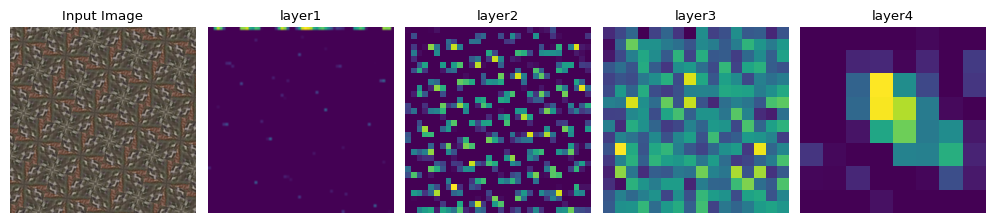

In [13]:
overlay_imgs['p4_pgg'] = image

model_type = 'ResNet50'
layers = ['layer1', 'layer2', 'layer3', 'layer4']

task_name = ''
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(image, layers, task_name, resnet50_100k, model_type, device, filename=None, viz=True)
overlay_imgs['ResNet50_layer1_p4_pgg'] = overlay_attention_map_list[0]
overlay_imgs['ResNet50_layer2_p4_pgg'] = overlay_attention_map_list[1]
overlay_imgs['ResNet50_layer3_p4_pgg'] = overlay_attention_map_list[2]
overlay_imgs['ResNet50_layer4_p4_pgg'] = overlay_attention_map_list[3]

../../figures/4.AttentionMap/figure3-ResNet50_100k-XCiT_100k-AttentionMap-p4_pgg-p4_p4.png
../../figures/4.AttentionMap/figure3-ResNet50_100k-XCiT_100k-AttentionMap-p4_pgg-p4_p4.svg
../../figures/4.AttentionMap/figure3-ResNet50_100k-XCiT_100k-AttentionMap-p4_pgg-p4_p4.tif


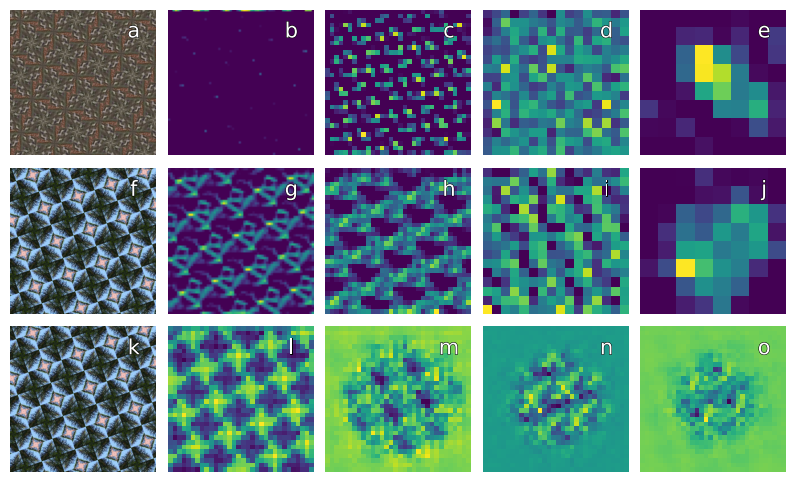

In [14]:
fig, axes = layout_fig(15, 5, figsize=(8, 5), subplot_style='subplots', layout='tight')

for i, name in enumerate([
    'p4_pgg', 'ResNet50_layer1_p4_pgg', 'ResNet50_layer2_p4_pgg', 'ResNet50_layer3_p4_pgg', 'ResNet50_layer4_p4_pgg', 
    'p4_p4', 'ResNet50_layer1_p4_p4', 'ResNet50_layer2_p4_p4', 'ResNet50_layer3_p4_p4', 'ResNet50_layer4_p4_p4', 
    'p4_p4', 'XCiT_layer0_p4_p4', 'XCiT_layer4_p4_p4', 'XCiT_layer7_p4_p4', 'XCiT_layer11_p4_p4']):
    axes[i].imshow(overlay_imgs[name])
    axes[i].axis('off')
    labelfigs(axes[i], number=i, style='wb', loc='tr', size=15)

printing.savefig(fig, 'figure3-ResNet50_100k-XCiT_100k-AttentionMap-p4_pgg-p4_p4')
plt.show()